# Pattern matching blog post

### Install Dependencies

In [17]:
import pandas as pd
from datetime import datetime
from datetime import time
import numpy as np
import matplotlib.pyplot as plot
import kdbai_client as kdbai
from getpass import getpass
import seaborn

### Read data into session

Here are some dummy financial data I saved to disk, consisting of hourly trade volumes for 10 syms over a period of 10 days (2400 records).


In [18]:
tab = pd.read_csv("hourly_volume_data.csv")
tab["datetime"] = pd.to_datetime(tab["datetime"])
tab['sym'] = tab['sym'].astype('string')
#tab.sort_values(by='datetime', ascending=True, inplace=True)

tab

,sym,datetime,size
0,AAPL,2023-10-13 00:00:00,30038
1,AAPL,2023-10-14 00:00:00,29882
2,AAPL,2023-10-15 00:00:00,29121
3,AAPL,2023-10-16 00:00:00,30449
4,AAPL,2023-10-17 00:00:00,30744
...,...,...,...
2395,MSFT,2023-10-18 23:00:00,29306
2396,MSFT,2023-10-19 23:00:00,30245
2397,MSFT,2023-10-20 23:00:00,33033
2398,MSFT,2023-10-21 23:00:00,29424


### Visualise the data

We have to restructure the data a bit to visualise it, we also normalise the data for this step

In [194]:
vis_tab = pd.DataFrame()

sym_list = tab["sym"].unique().tolist()

# Iterate through the DataFrame with the specified step size
for x in sym_list:
    extract = tab.loc[tab['sym'] == x]
    values = np.array(extract["size"])
    normvalues = (values-np.min(values))/(np.max(values)-np.min(values))
    vis_tab[x] = values

vis_tab["datetime"] = tab["datetime"]
vis_tab.sort_values(by='datetime', ascending=True, inplace=True)
vis_tab

,AAPL,AIG,AMD,DELL,DOW,GOOG,HPQ,IBM,INTC,MSFT,datetime
0,30038,155547,251012,285012,215413,413054,412630,424441,266131,31352,2023-10-13 00:00:00
10,29945,157772,254834,305479,226400,439406,414734,423187,279726,30459,2023-10-13 01:00:00
20,29610,160832,250034,301583,217864,424440,401262,423194,270063,33277,2023-10-13 02:00:00
30,30708,159797,257387,295873,223759,429806,410508,430748,276771,29688,2023-10-13 03:00:00
40,29864,156808,248568,299892,214805,430136,405906,418966,274774,37386,2023-10-13 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
199,31689,159571,255753,302357,226259,438460,421673,433677,275690,32891,2023-10-22 19:00:00
209,31301,159755,252810,295243,220843,429882,418050,425474,276252,28150,2023-10-22 20:00:00
219,30160,162220,255681,304543,228946,426396,418327,426290,276162,35959,2023-10-22 21:00:00
229,31529,158436,249576,308061,230414,428468,414808,421144,273301,27156,2023-10-22 22:00:00


/opt/kx/mambaforge/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/kx/mambaforge/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


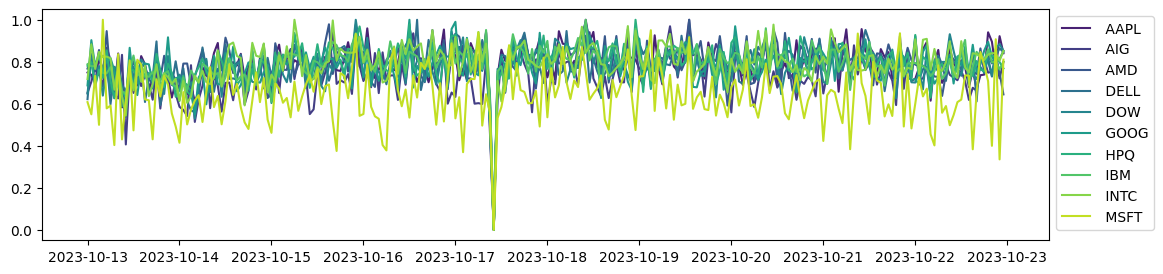

In [4]:
# Iterate through sym list and plot data
plot.figure(figsize=(13, 3))

viridis = ('#482173', '#433e85', '#38588c', '#2d708e', '#25858e', '#1e9b8a', '#2ab07f', '#52c569', '#86d549', '#c2df23')
ccounter= 0

for x in sym_list:
    plot.plot(vis_tab["datetime"], vis_tab[x], color=viridis[ccounter], label = f" {x}")
    ccounter +=1
plot.legend( bbox_to_anchor=(1, 1), loc='upper left')

## hands-on 1 - historical market performance (one sym)

The windows here will consist of subsequences within one timeseries for one sym, "AAPL". 

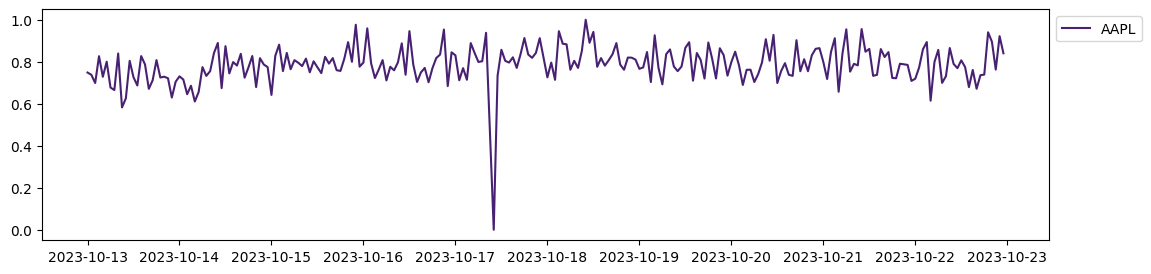

In [5]:
# Plot AAPL data
plot.figure(figsize=(13, 3))

plot.plot(vis_tab["datetime"], vis_tab["AAPL"], color='#482173', label = "AAPL")
plot.legend( bbox_to_anchor=(1, 1), loc='upper left')

## 1. Create vector embeddings

In [20]:
df = tab.loc[tab['sym'] == "AAPL"]
df.sort_values(by='datetime', ascending=True, inplace=True)

# Set the window size (12 hour windows (36 x 20 minutes), 6 hour overlap (18 x 20 minutes))
window_size = 12
step_size = 3

# Initialize empty lists to store results
start_times = []
end_times = []
volumes = []

# Iterate through the DataFrame with the specified step size
for i in range(0, len(df) - window_size + 1, step_size):
    window = df.iloc[i : i + window_size]
    start_time = window["datetime"].iloc[0]
    end_time = window["datetime"].iloc[-1]
    values= window["size"].tolist()
    start_times.append(start_time)
    end_times.append(end_time)
    volumes.append(values)

# Create a new DataFrame from the collected data
result_data = {"startTime": start_times, "endTime": end_times, "vectors": volumes}
result_df = pd.DataFrame(result_data)

/tmp/ipykernel_446/494629098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='datetime', ascending=True, inplace=True)


In [21]:
# Find the minimum and maximum values for the entire DataFrame
min_value = result_df["vectors"].apply(min).min()
max_value = result_df["vectors"].apply(max).max()

# Normalize the "vectors" column
result_df["vectors"] = result_df["vectors"].apply(
    lambda x: [(v - min_value) / (max_value - min_value) for v in x]
)

# Print the resulting DataFrame
print(result_df)

# Reset the index
result_df

             startTime             endTime  \
0  2023-10-13 00:00:00 2023-10-13 11:00:00   
1  2023-10-13 03:00:00 2023-10-13 14:00:00   
2  2023-10-13 06:00:00 2023-10-13 17:00:00   
3  2023-10-13 09:00:00 2023-10-13 20:00:00   
4  2023-10-13 12:00:00 2023-10-13 23:00:00   
..                 ...                 ...   
72 2023-10-22 00:00:00 2023-10-22 11:00:00   
73 2023-10-22 03:00:00 2023-10-22 14:00:00   
74 2023-10-22 06:00:00 2023-10-22 17:00:00   
75 2023-10-22 09:00:00 2023-10-22 20:00:00   
76 2023-10-22 12:00:00 2023-10-22 23:00:00   

                                              vectors  
0   [0.7487227124941942, 0.7379238272178356, 0.699...  
1   [0.8265211333023688, 0.7285183464932652, 0.800...  
2   [0.6773107292150488, 0.665466790524849, 0.8395...  
3   [0.582559219693451, 0.6256386437529029, 0.8043...  
4   [0.7261960055736182, 0.6871806781235485, 0.827...  
..                                                ...  
72  [0.7194612169066419, 0.7727589410125406, 0.859...  

,startTime,endTime,vectors
0,2023-10-13 00:00:00,2023-10-13 11:00:00,"[0.7487227124941942, 0.7379238272178356, 0.699..."
1,2023-10-13 03:00:00,2023-10-13 14:00:00,"[0.8265211333023688, 0.7285183464932652, 0.800..."
2,2023-10-13 06:00:00,2023-10-13 17:00:00,"[0.6773107292150488, 0.665466790524849, 0.8395..."
3,2023-10-13 09:00:00,2023-10-13 20:00:00,"[0.582559219693451, 0.6256386437529029, 0.8043..."
4,2023-10-13 12:00:00,2023-10-13 23:00:00,"[0.7261960055736182, 0.6871806781235485, 0.827..."
...,...,...,...
72,2023-10-22 00:00:00,2023-10-22 11:00:00,"[0.7194612169066419, 0.7727589410125406, 0.859..."
73,2023-10-22 03:00:00,2023-10-22 14:00:00,"[0.8939851370181142, 0.614723641430562, 0.7987..."
74,2023-10-22 06:00:00,2023-10-22 17:00:00,"[0.8564793311658151, 0.6996052020436601, 0.731..."
75,2023-10-22 09:00:00,2023-10-22 20:00:00,"[0.8656525777984209, 0.7897120297259638, 0.769..."


## 2. Store embeddings in KDB.AI

### Connect to KDB.AI session

In [22]:
KDBAI_ENDPOINT = input('KDB.AI endpoint: ')
KDBAI_API_KEY = getpass('KDB.AI API key: ')
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

KDB.AI endpoint: https://cloud.kdb.ai/instance/rgqpft7sjs
KDB.AI API key: ········


### Define Schema, create table and store embeddings

The schema of the table you insert should match that of the schema you define here, same columns, and importantly, the same 'pytype'.

In [23]:
# Define Schema
market_schema = {
    "columns": [
        {
            "name": "startTime",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "endTime",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "vectors",
            "vectorIndex": {"dims": window_size, "metric": "L2", "type": "hnsw"},
        },
    ]
}

# Create table
#table = session.create_table("trade_volume1", market_schema)

# Load table
table = session.table("trade_volume1")

# Insert data
#table.insert(result_df)

# Query KDB.AI table
table.query()

,startTime,endTime,vectors
0,2023-10-13 00:00:00,2023-10-13 11:00:00,"[0.7487227124941942, 0.7379238272178356, 0.699..."
1,2023-10-13 03:00:00,2023-10-13 14:00:00,"[0.8265211333023688, 0.7285183464932652, 0.800..."
2,2023-10-13 06:00:00,2023-10-13 17:00:00,"[0.6773107292150488, 0.665466790524849, 0.8395..."
3,2023-10-13 09:00:00,2023-10-13 20:00:00,"[0.582559219693451, 0.6256386437529029, 0.8043..."
4,2023-10-13 12:00:00,2023-10-13 23:00:00,"[0.7261960055736182, 0.6871806781235485, 0.827..."
...,...,...,...
72,2023-10-22 00:00:00,2023-10-22 11:00:00,"[0.7194612169066419, 0.7727589410125406, 0.859..."
73,2023-10-22 03:00:00,2023-10-22 14:00:00,"[0.8939851370181142, 0.614723641430562, 0.7987..."
74,2023-10-22 06:00:00,2023-10-22 17:00:00,"[0.8564793311658151, 0.6996052020436601, 0.731..."
75,2023-10-22 09:00:00,2023-10-22 20:00:00,"[0.8656525777984209, 0.7897120297259638, 0.769..."


## 3. Historical market analysis

Now lets perform the analysis by comparing a query vector with the historical AAPL trade volume data

In [12]:
print(seaborn.color_palette('viridis', 5).as_hex())

['#443983', '#31688e', '#21918c', '#35b779', '#90d743']


(array([19652.5       , 19652.58333333, 19652.66666667, 19652.75      ,
        19652.83333333, 19652.91666667]),
 [Text(19652.5, 0, '10-22 12'),
  Text(19652.583333333332, 0, '10-22 14'),
  Text(19652.666666666668, 0, '10-22 16'),
  Text(19652.75, 0, '10-22 18'),
  Text(19652.833333333332, 0, '10-22 20'),
  Text(19652.916666666668, 0, '10-22 22')])

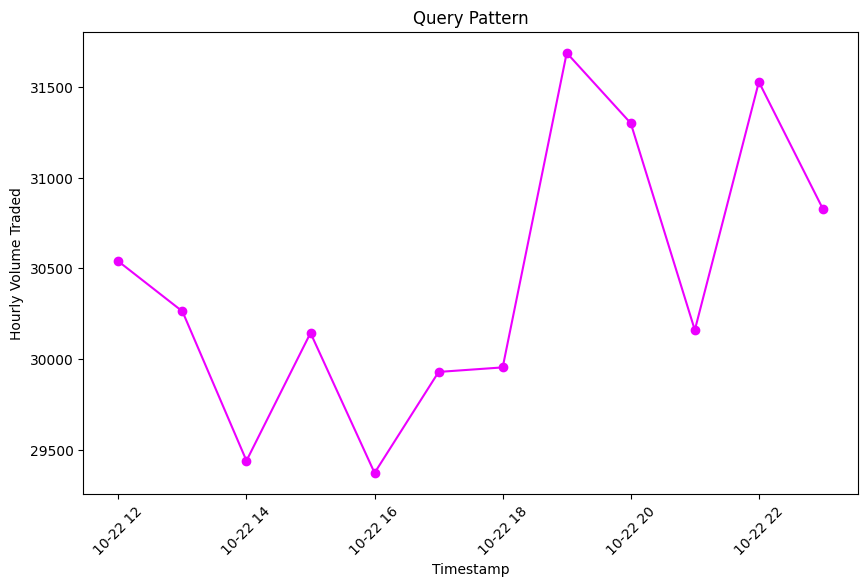

In [34]:
## Select historical pattern
random_start_time = pd.to_datetime("2023-10-22 12:00:00")

# Filter result_df based on the specific startTime
query_vector = result_df[result_df["startTime"] == random_start_time]["vectors"].values.tolist()

## Select historical pattern
df_query_times = result_df[result_df["startTime"] == random_start_time]
query_df = df[(df["datetime"] >= df_query_times.iloc[0]["startTime"]) & (df["datetime"] <= df_query_times.iloc[0]["endTime"])]

# Create a line plot
plot.figure(figsize=(10, 6))
plot.plot(query_df["datetime"], query_df["size"], marker="o", linestyle="-", color = '#EC00FF')
plot.xlabel("Timestamp")
plot.ylabel("Hourly Volume Traded")
plot.title("Query Pattern")
plot.xticks(rotation=45) 


In [25]:
# search for 5 nearest neighbours based on query sequence
result = table.search(query_vector, n=5)
result[0]

,startTime,endTime,vectors,__nn_distance
0,2023-10-22 12:00:00,2023-10-22 23:00:00,"[0.8068973525313516, 0.7748490478402229, 0.679...",0.000000
1,2023-10-14 18:00:00,2023-10-15 05:00:00,"[0.7734556432884347, 0.8274500696702276, 0.679...",0.056104
2,2023-10-15 12:00:00,2023-10-15 23:00:00,"[0.7735717603344171, 0.7460520204366001, 0.823...",0.070270
3,2023-10-18 21:00:00,2023-10-19 08:00:00,"[0.8201346957733395, 0.8195541105434277, 0.810...",0.071772
4,2023-10-15 15:00:00,2023-10-16 02:00:00,"[0.7913376683697166, 0.8174640037157455, 0.759...",0.077612


In [120]:
print(seaborn.color_palette('viridis', 5).as_hex())
seaborn.color_palette('viridis', 5)
#print(seaborn.color_palette('viridis', 5))

['#443983', '#31688e', '#21918c', '#35b779', '#90d743']


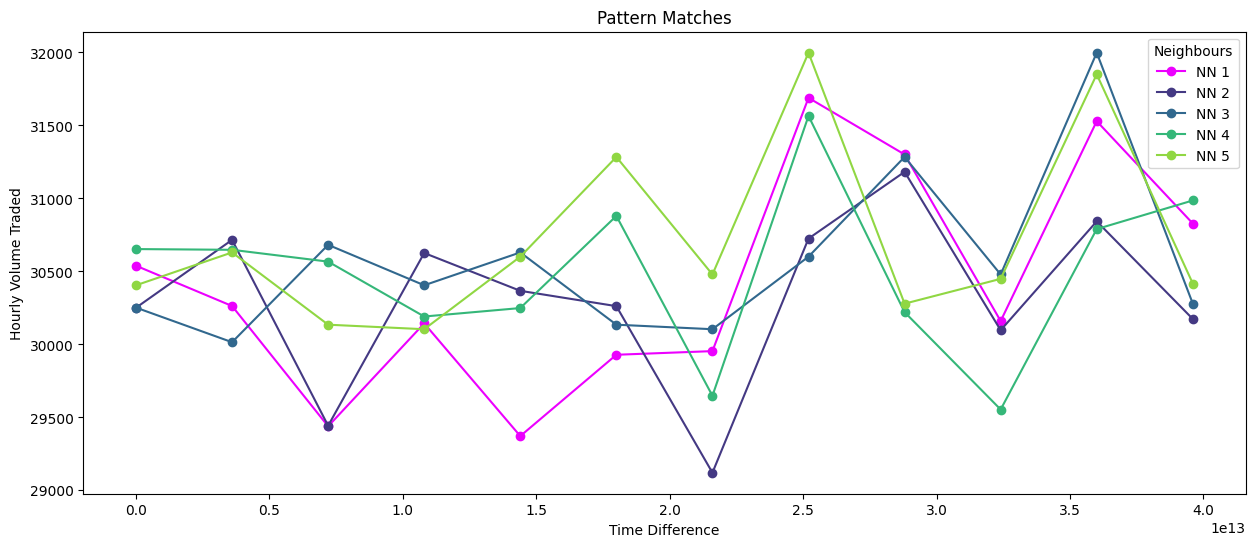

In [41]:
df1 = df
df2 = result[0]

# Create a list to store the results
result_list = []
# Initialize label counter
label_counter = 1

# Iterate through the rows of df2 to filter df1 and calculate time differences
for index, row in df2.iterrows():
    mask = (df1["datetime"] >= row["startTime"]) & (df1["datetime"] <= row["endTime"])
    filtered_df = df1[mask].copy()  # Create a copy of the filtered DataFrame
    filtered_df["time_difference"] = filtered_df["datetime"] - row["startTime"]
    filtered_df["pattern"] = label_counter
    label_counter += 1  # Increment the label counter
    result_list.append(filtered_df)

# Concatenate the results into a new DataFrame
result_df2 = pd.concat(result_list)

# Group by 'label_counter' and plot each group separately with a legend
groups = result_df2.groupby("pattern")

ccounter = 0
viridis = ['#EC00FF', '#443983', '#31688e', '#35b779', '#90d743']

fig, ax = plot.subplots(figsize=(15, 6))

for name, group in groups:
    ax.plot(
        group["time_difference"], group["size"], color = viridis[ccounter], marker="o", label=f"NN {name}"
    )
    ccounter +=1


ax.set_ylabel("Hourly Volume Traded")
ax.legend(title="Neighbours")
ax.set_xlabel("Time Difference")
plot.title("Pattern Matches")
plot.show()

In [28]:
vis_tab["AAPL"]

0      0.748723
10     0.737924
20     0.699025
30     0.826521
40     0.728518
         ...   
199    0.940432
209    0.895379
219    0.762889
229    0.921853
239    0.840455
Name: AAPL, Length: 240, dtype: float64

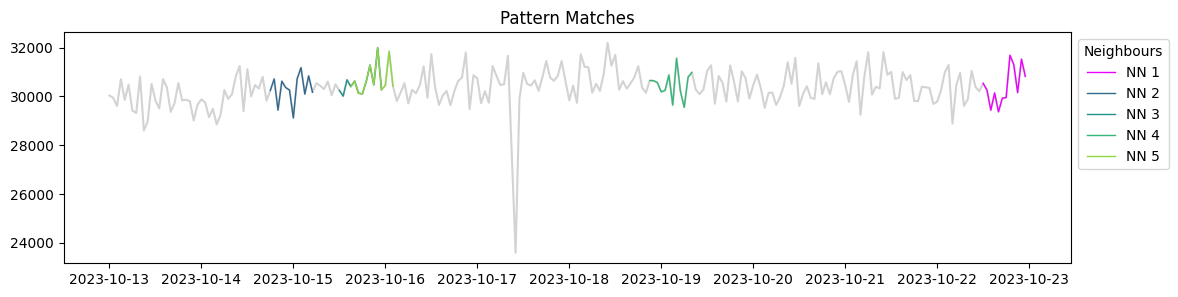

In [52]:
result_list1 = {}
label_counter1=1
viridis = ['#EC00FF', '#443983', '#31688e', '#35b779', '#90d743']

for i in df2.index:
    mask = (df['datetime'] >= df2.loc[i]['startTime']) & (df['datetime'] <= df2.loc[i]['endTime'])
    res = df.loc[mask]
    result_list1[label_counter1] = pd.DataFrame(res)
    label_counter1 +=1

# Plot on AAPL timeseries
ccounter = 0
viridis = ['#EC00FF', '#31688e', '#21918c', '#35b779', '#90d743']
plot.figure(figsize=(13, 3))

plot.plot(vis_tab["datetime"], vis_tab["AAPL"], color='lightgrey')
for j in range(1,1+ len(df2)):
    plot.plot(result_list1[j]["datetime"], result_list1[j]["size"], linewidth=1,color = viridis[ccounter], label=f"NN {j}", alpha=1
              
             )
    ccounter +=1


plot.legend( bbox_to_anchor=(1, 1), loc='upper left', title="Neighbours")
ax.set_ylabel("Hourly Volume Traded")
ax.set_xlabel("Time Difference")
plot.title("Pattern Matches")
plot.show()


## hands-on 2 - historical market performance (multiple syms)

## 1. Create vector embeddings

In [126]:
sym_list = tab["sym"].unique().tolist()
sym_count = 0
total_df = pd.DataFrame()

# Iterate through the DataFrame with the specified step size
for x in sym_list:
    data = tab.loc[tab['sym'] == x]
    data.sort_values(by='datetime', ascending=True, inplace=True)
    # Window parameters
    window_size = 12
    step_size = 3
    # Initialize empty lists
    start_times = []
    end_times = []
    volumes = []
    
    # Create windows
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i : i + window_size]
        start_time = window["datetime"].iloc[0]
        end_time = window["datetime"].iloc[-1]
        values= window["size"].tolist()
        start_times.append(start_time)
        end_times.append(end_time)
        volumes.append(values)
        
    result_data = {"esym": sym_count, "startTime": start_times, "endTime": end_times, "vectors": volumes}
    result_df = pd.DataFrame(result_data)
    # Normalise
    min_value = result_df["vectors"].apply(min).min()
    max_value = result_df["vectors"].apply(max).max()
    result_df["vectors"] = result_df["vectors"].apply(
        lambda x: [(v - min_value) / (max_value - min_value) for v in x]
    )
    
    total_df = total_df.append(result_df, ignore_index = True)
    sym_count+=1
        
total_df    

/tmp/ipykernel_446/3678278244.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='datetime', ascending=True, inplace=True)
/tmp/ipykernel_446/3678278244.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = total_df.append(result_df, ignore_index = True)
/tmp/ipykernel_446/3678278244.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='datetime', ascending=True, inplace=True)
/tmp/ipykernel_446/3678278244.py:36: FutureWarning: The frame.append method is deprecated and will be remov

,esym,startTime,endTime,vectors
0,0,2023-10-13 00:00:00,2023-10-13 11:00:00,"[0.7487227124941942, 0.7379238272178356, 0.699..."
1,0,2023-10-13 03:00:00,2023-10-13 14:00:00,"[0.8265211333023688, 0.7285183464932652, 0.800..."
2,0,2023-10-13 06:00:00,2023-10-13 17:00:00,"[0.6773107292150488, 0.665466790524849, 0.8395..."
3,0,2023-10-13 09:00:00,2023-10-13 20:00:00,"[0.582559219693451, 0.6256386437529029, 0.8043..."
4,0,2023-10-13 12:00:00,2023-10-13 23:00:00,"[0.7261960055736182, 0.6871806781235485, 0.827..."
...,...,...,...,...
765,9,2023-10-22 00:00:00,2023-10-22 11:00:00,"[0.6010918307662312, 0.7263924091765777, 0.635..."
766,9,2023-10-22 03:00:00,2023-10-22 14:00:00,"[0.6719958406447001, 0.4548644960031195, 0.401..."
767,9,2023-10-22 06:00:00,2023-10-22 17:00:00,"[0.7827386755052966, 0.5572236303372977, 0.589..."
768,9,2023-10-22 09:00:00,2023-10-22 20:00:00,"[0.4978878273867551, 0.5461753428218626, 0.607..."


## 2. Store embeddings in KDB.AI

In [88]:
KDBAI_ENDPOINT = input('KDB.AI endpoint: ')
KDBAI_API_KEY = getpass('KDB.AI API key: ')
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

KDB.AI endpoint: https://cloud.kdb.ai/instance/rgqpft7sjs
KDB.AI API key: ········


In [128]:
# Define Schema
market_schema = {
    "columns": [
        {
            "name": "esym",
            "pytype": "int64",
        },
        {
            "name": "startTime",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "endTime",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "vectors",
            "vectorIndex": {"dims": window_size, "metric": "L2", "type": "hnsw"},
        },
    ]
}

# Create table
table = session.create_table("trade_volume2", market_schema)

# Load table
#table = session.table("trade_volume2")
#table.drop()
# Insert data
table.insert(total_df)

# Query KDB.AI table
table.query()

,esym,startTime,endTime,vectors
0,0,2023-10-13 00:00:00,2023-10-13 11:00:00,"[0.7487227124941942, 0.7379238272178356, 0.699..."
1,0,2023-10-13 03:00:00,2023-10-13 14:00:00,"[0.8265211333023688, 0.7285183464932652, 0.800..."
2,0,2023-10-13 06:00:00,2023-10-13 17:00:00,"[0.6773107292150488, 0.665466790524849, 0.8395..."
3,0,2023-10-13 09:00:00,2023-10-13 20:00:00,"[0.582559219693451, 0.6256386437529029, 0.8043..."
4,0,2023-10-13 12:00:00,2023-10-13 23:00:00,"[0.7261960055736182, 0.6871806781235485, 0.827..."
...,...,...,...,...
765,9,2023-10-22 00:00:00,2023-10-22 11:00:00,"[0.6010918307662312, 0.7263924091765777, 0.635..."
766,9,2023-10-22 03:00:00,2023-10-22 14:00:00,"[0.6719958406447001, 0.4548644960031195, 0.401..."
767,9,2023-10-22 06:00:00,2023-10-22 17:00:00,"[0.7827386755052966, 0.5572236303372977, 0.589..."
768,9,2023-10-22 09:00:00,2023-10-22 20:00:00,"[0.4978878273867551, 0.5461753428218626, 0.607..."


## 3. Historical market analysis

In [129]:
# search for 5 nearest neighbours based on query sequence
result = table.search(query_vector, n=5)
result[0]

,esym,startTime,endTime,vectors,__nn_distance
0,0,2023-10-22 12:00:00,2023-10-22 23:00:00,"[0.8068973525313516, 0.7748490478402229, 0.679...",0.000000
1,8,2023-10-19 21:00:00,2023-10-20 08:00:00,"[0.8396191960263933, 0.7435051496189525, 0.654...",0.029033
2,5,2023-10-19 18:00:00,2023-10-20 05:00:00,"[0.8500302391343435, 0.7367887673875022, 0.763...",0.039041
3,8,2023-10-15 09:00:00,2023-10-15 20:00:00,"[0.8318278103771518, 0.7012125343916632, 0.720...",0.047576
4,7,2023-10-16 00:00:00,2023-10-16 11:00:00,"[0.79341019894175, 0.8208908092454386, 0.78664...",0.054452


,sym,datetime,size
0,AAPL,2023-10-13 00:00:00,30038
1,AAPL,2023-10-14 00:00:00,29882
2,AAPL,2023-10-15 00:00:00,29121
3,AAPL,2023-10-16 00:00:00,30449
4,AAPL,2023-10-17 00:00:00,30744
...,...,...,...
2395,MSFT,2023-10-18 23:00:00,29306
2396,MSFT,2023-10-19 23:00:00,30245
2397,MSFT,2023-10-20 23:00:00,33033
2398,MSFT,2023-10-21 23:00:00,29424


/tmp/ipykernel_446/2058695794.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.sort_values(by='datetime', ascending=True, inplace=True)
/tmp/ipykernel_446/2058695794.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.sort_values(by='datetime', ascending=True, inplace=True)
/tmp/ipykernel_446/2058695794.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.sort_values(by='datetime', ascending=True, inplace=True)
/tmp/ip

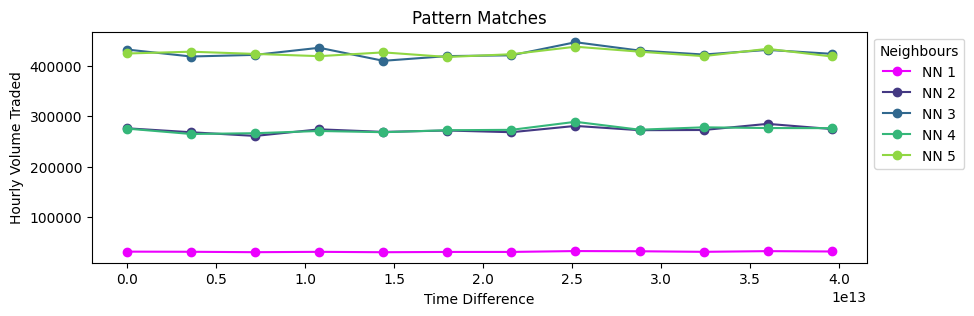

In [198]:
df2 = result[0]

# Create a list to store the results
result_list = []
# Initialize label counter
label_counter = 1
ccounter = 0

# Iterate through the rows of df2 to filter df1 and calculate time differences
for index, row in df2.iterrows():
    df1 = tab.loc[tab['sym'] == sym_list[row["esym"]]]
    df1.sort_values(by='datetime', ascending=True, inplace=True)
    mask = (df1["datetime"] >= row["startTime"]) & (df1["datetime"] <= row["endTime"])
    filtered_df = df1[mask].copy()  # Create a copy of the filtered DataFrame
    filtered_df["time_difference"] = filtered_df["datetime"] - row["startTime"]
    filtered_df["pattern"] = label_counter
    filtered_df["colour"] = ccounter
    label_counter += 1  # Increment the label counter
    ccounter += 1
    result_list.append(filtered_df)
    result_df2 = pd.concat(result_list)

# Group by 'label_counter' and plot each group separately with a legend
groups = result_df2.groupby("pattern")

# plotting
viridis = ['#EC00FF', '#443983', '#31688e', '#35b779', '#90d743']

fig, ax = plot.subplots(figsize=(10, 3))
for name, group in groups:
    ax.plot(
        group["time_difference"], group["size"], color= viridis[group["colour"].iloc[1]], marker="o", label=f"NN {name}"
    )


ax.set_ylabel("Hourly Volume Traded")
plot.legend( bbox_to_anchor=(1, 1), loc='upper left', title="Neighbours")
ax.set_xlabel("Time Difference")
plot.title("Pattern Matches")
plot.show() 
    

In [204]:
result_df2
ccounter = 0
viridis = ['#EC00FF', '#31688e', '#21918c', '#35b779', '#90d743']

# Plot ach timeseries
for name, group in groups:
    plot.figure(figsize=(13, 3))
    plot.plot(vis_tab["datetime"], vis_tab[group["sym"].iloc[0]], color='lightgrey')
    plot.plot(group["datetime"], group["size"], color= viridis[group["colour"].iloc[1]], label=f"NN {name} ")
    
    ax.set_ylabel("Hourly Volume Traded")
    ax.set_xlabel("Datetime")
    plot.legend( bbox_to_anchor=(1, 1), loc='upper left', title="Neighbours")
    plot.title("Pattern Matches")
    plot.show()

,sym,datetime,size,time_difference,pattern,colour
129,AAPL,2023-10-22 12:00:00,30539,0 days 00:00:00,1,0
139,AAPL,2023-10-22 13:00:00,30263,0 days 01:00:00,1,0
149,AAPL,2023-10-22 14:00:00,29439,0 days 02:00:00,1,0
159,AAPL,2023-10-22 15:00:00,30144,0 days 03:00:00,1,0
169,AAPL,2023-10-22 16:00:00,29372,0 days 04:00:00,1,0
179,AAPL,2023-10-22 17:00:00,29929,0 days 05:00:00,1,0
189,AAPL,2023-10-22 18:00:00,29954,0 days 06:00:00,1,0
199,AAPL,2023-10-22 19:00:00,31689,0 days 07:00:00,1,0
209,AAPL,2023-10-22 20:00:00,31301,0 days 08:00:00,1,0
219,AAPL,2023-10-22 21:00:00,30160,0 days 09:00:00,1,0


In [184]:
result_df2

,sym,datetime,size,time_difference,pattern,colour
129,AAPL,2023-10-22 12:00:00,30539,0 days 00:00:00,1,0
139,AAPL,2023-10-22 13:00:00,30263,0 days 01:00:00,1,0
149,AAPL,2023-10-22 14:00:00,29439,0 days 02:00:00,1,0
159,AAPL,2023-10-22 15:00:00,30144,0 days 03:00:00,1,0
169,AAPL,2023-10-22 16:00:00,29372,0 days 04:00:00,1,0
179,AAPL,2023-10-22 17:00:00,29929,0 days 05:00:00,1,0
189,AAPL,2023-10-22 18:00:00,29954,0 days 06:00:00,1,0
199,AAPL,2023-10-22 19:00:00,31689,0 days 07:00:00,1,0
209,AAPL,2023-10-22 20:00:00,31301,0 days 08:00:00,1,0
219,AAPL,2023-10-22 21:00:00,30160,0 days 09:00:00,1,0


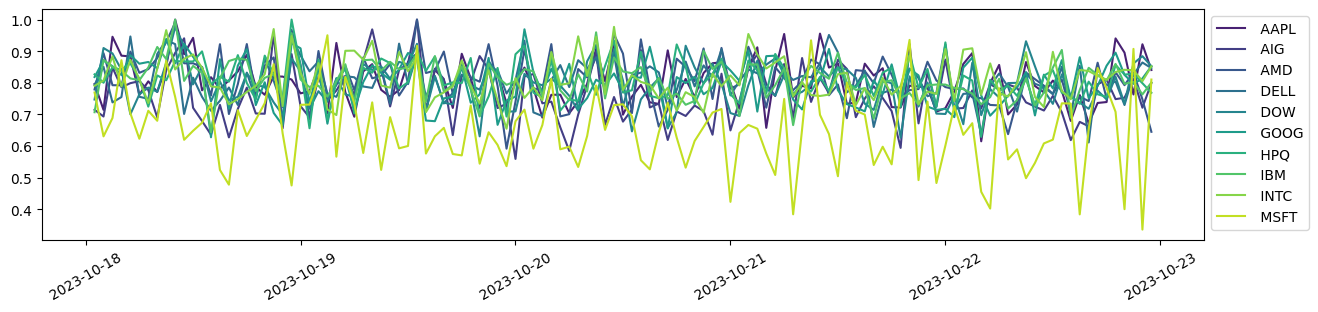

In [66]:
vis_tab_5 = vis_tab[vis_tab.datetime > '2023-10-18 00:00:00']
sym_list = tab["sym"].unique().tolist()

viridis = ('#482173', '#433e85', '#38588c', '#2d708e', '#25858e', '#1e9b8a', '#2ab07f', '#52c569', '#86d549', '#c2df23')
ccounter= 0
plot.figure(figsize=(15, 3))

for x in sym_list:
    plot.plot(vis_tab_5["datetime"], vis_tab_5[x], color=viridis[ccounter], label = f" {x}")
    ccounter +=1
plot.legend( bbox_to_anchor=(1, 1), loc='upper left')

plot.xticks(rotation=30, fontsize = 10)
ax.set_ylabel("Hourly Volume Traded ")
ax.legend(title="Neighbours")
ax.set_xlabel("Time Difference")
plot.show()


In [ ]:
plot.figure(figsize=(18, 3))
plot.plot(vis_tab["datetime"], vis_tab["AAPL"], color="blue")